In [7]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import random
import ipyplot

from utils import *

load_dotenv()
Migrator().run()

In [8]:
query = "volume1"
delete = Model.find(Model.filename % query).all()
for r in tqdm(delete, desc="Deleting existing keys"):
    try:
        Model.delete(r.pk)
    except Exception as e:
        print("There was an exception with {}\n{}".format(r, e))

Deleting existing keys:   0%|          | 0/49068 [00:00<?, ?it/s]

In [9]:
CONTAINER_IMAGE_FOLDER = "/volume1/local_only/pictures"
filenames = index_directory(CONTAINER_IMAGE_FOLDER)
for filename in tqdm(filenames, desc="Writing filenames to redis db."):
    Model(filename=filename).save()

Indexed 49,068 file(s) in 0.615 seconds.


Writing filenames to redis db.:   0%|          | 0/49068 [00:00<?, ?it/s]

In [10]:
models = Model.find(Model.filename % query).all()
print(len(models))

49068


In [11]:
triton_client = grpcclient.InferenceServerClient(url=TRITON_SERVER_URL, verbose=False)
model_metadata = triton_client.get_model_metadata(
    model_name=FACE_DETECT_MODEL_NAME, model_version=MODEL_VERSION
)
model_config = triton_client.get_model_config(
    model_name=FACE_DETECT_MODEL_NAME, model_version=MODEL_VERSION
).config
input_names = [i.name for i in model_config.input]
output_names = [i.name for i in model_config.output]

Generating some examples with bbox rendering.:   0%|          | 0/49068 [00:00<?, ?it/s]


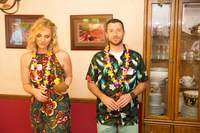
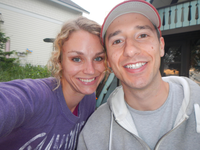
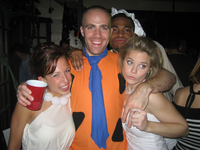
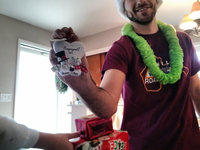
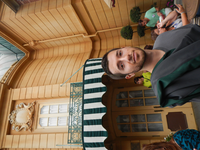
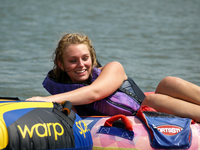
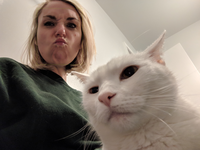
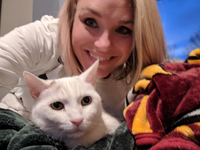


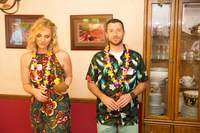
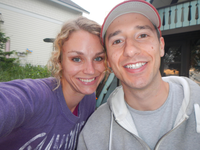
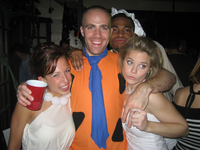
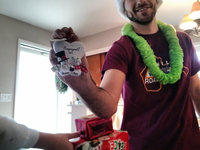
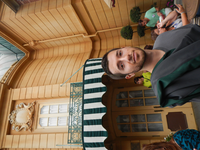
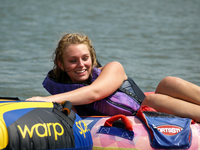
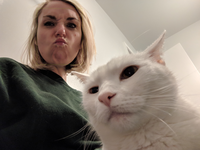
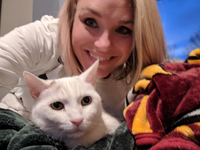

In [12]:
n = 0
max_images = 8
show_me_grid = []
show_me_labels = []
for model in tqdm(models, desc="Generating some examples with bbox rendering."):
    if n <= max_images:
        try:
            infer_result = submit_to_facedetect(
                model.filename, input_names, output_names, request_id=model.pk
            )
            if len(infer_result.as_numpy(output_names[1])) != 0:
                image_wise_bboxes = infer_result.as_numpy(output_names[0]).reshape(
                    -1, 4
                )
                img = render_image(
                    model.filename, image_wise_bboxes, linewidth=10, output_size=200
                )
                show_me_grid.append(img)
                show_me_labels.append(
                    "{} face(s) found in {}".format(
                        len(infer_result.as_numpy(output_names[1])), model.filename
                    )
                )
                n += 1

        except Exception as e:
            print("There was an exception: {}.".format(e))
    else:
        break

ipyplot.plot_images(
    show_me_grid,
    labels=show_me_labels,
    max_images=max_images,
    img_width=400,
    show_url=False,
)

In [ ]:
pbar = tqdm(
    total=len(models),
    desc="Submitting photos to {} at {}".format(
        FACE_DETECT_MODEL_NAME, TRITON_SERVER_URL
    ),
)

results = []

with ThreadPoolExecutor() as executor:
    for chunk in chunked(models, THREAD_CHUNKS):
        futures = []
        for model in chunk:
            futures.append(
                executor.submit(
                    submit_to_facedetect,
                    model.filename,
                    input_names,
                    output_names,
                    model.pk,
                )
            )

        for future in as_completed(futures):
            pbar.update()
            try:
                infer_result = future.result()
                model = Model.get(infer_result.get_response().id)
                image_wise_bboxes = infer_result.as_numpy(output_names[0]).reshape(
                    -1, 4
                )
                image_probas = infer_result.as_numpy(output_names[1]).reshape(-1, 1)
                for bbox, proba in zip(image_wise_bboxes, image_probas):
                    model.faces = [
                        {
                            "bbox": {
                                "x1": int(bbox[0]),
                                "y1": int(bbox[1]),
                                "x2": int(bbox[2]),
                                "y2": int(bbox[3]),
                            },
                            "probability": int(proba[0]),
                        }
                        for bbox, proba in zip(image_wise_bboxes, image_probas)
                    ]
                model.save()

            except Exception as e:
                print("There was an exception: {}.".format(e))

In [ ]:
# Re-query since it's all been updated.
models = Model.find(Model.filename % query).all()

for model in random.sample(models, len(models) - 1):
    try:
        if len(model.faces) > 2:
            print(
                "Looks like {} has {} faces.\n".format(model.filename, len(model.faces))
            )
            break
        else:
            continue
    except:
        pass
print(model.dict())
image_wise_boxes = []
for face in model.faces:
    image_wise_boxes.append([face.bbox.x1, face.bbox.y1, face.bbox.x2, face.bbox.y2])
render_image(model.filename, image_wise_boxes, output_size=800)

___